In [19]:
pip install shap

In [20]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import shap

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/Fibovin/des_modelos_1/refs/heads/main/Student_Performance.csv')
df.head(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [22]:
#Paso 1
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0}) #Codificamos la variable Extracurricular Activities ya que es categorica

## **Split de los datos**

In [23]:
#Separamos las variables preiotras de la variable objetivo
X = df.drop(columns=["Performance Index"])
y = df["Performance Index"]

## **Entrenamiento del modelo - Regresión con árbol de decisión**

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Dividimos los datos en un 80-20

#Creamos el modelo de regresión con árbol de decisión
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

#Realizamos las predicciones en el conjunto de entrenamiento y prueba
y_train_pred_tree = tree_model.predict(X_train)
y_test_pred_tree = tree_model.predict(X_test)

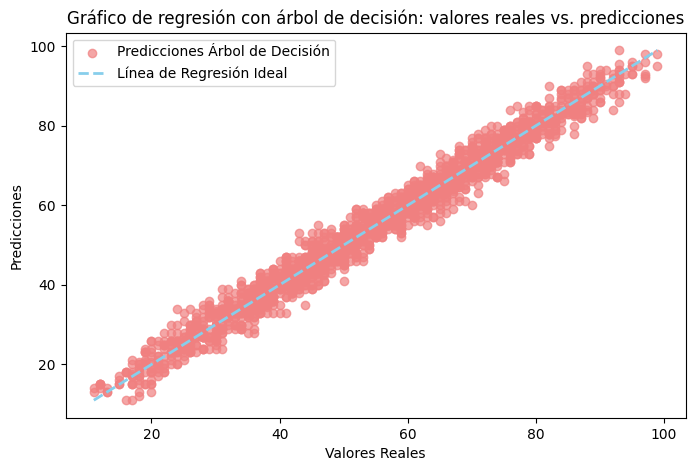

In [25]:
#Graficamos la regresión con el árbol de decisión
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_test_pred_tree, color="lightcoral", label="Predicciones Árbol de Decisión", alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="skyblue", linestyle="--", lw=2, label="Línea de Regresión Ideal")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Gráfico de regresión con árbol de decisión: valores reales vs. predicciones")
plt.legend()
plt.show()

## **Evaluación del modelo - regresión con árbol de decisión**

In [26]:
# Calcular métricas para el conjunto de entrenamiento
r2_train_tree = r2_score(y_train, y_train_pred_tree)
mse_train_tree = mean_squared_error(y_train, y_train_pred_tree)
mae_train_tree = mean_absolute_error(y_train, y_train_pred_tree)

# Calcular métricas para el conjunto de prueba
r2_test_tree = r2_score(y_test, y_test_pred_tree)
mse_test_tree = mean_squared_error(y_test, y_test_pred_tree)
mae_test_tree = mean_absolute_error(y_test, y_test_pred_tree)

# Crear la tabla con los resultados
tree_results = [
    ["Entrenamiento", r2_train_tree, mse_train_tree, mae_train_tree],
    ["Prueba", r2_test_tree, mse_test_tree, mae_test_tree]
]

# Imprimir en formato de tabla con tabulate
print(tabulate(tree_results, headers=["Conjunto", "R²", "MSE", "MAE"], tablefmt="fancy_grid", floatfmt="g"))

╒═══════════════╤══════════╤══════════╤══════════╕
│ Conjunto      │       R² │      MSE │      MAE │
╞═══════════════╪══════════╪══════════╪══════════╡
│ Entrenamiento │ 0.999305 │ 0.256375 │ 0.139458 │
├───────────────┼──────────┼──────────┼──────────┤
│ Prueba        │ 0.97622  │ 8.81269  │ 2.33783  │
╘═══════════════╧══════════╧══════════╧══════════╛


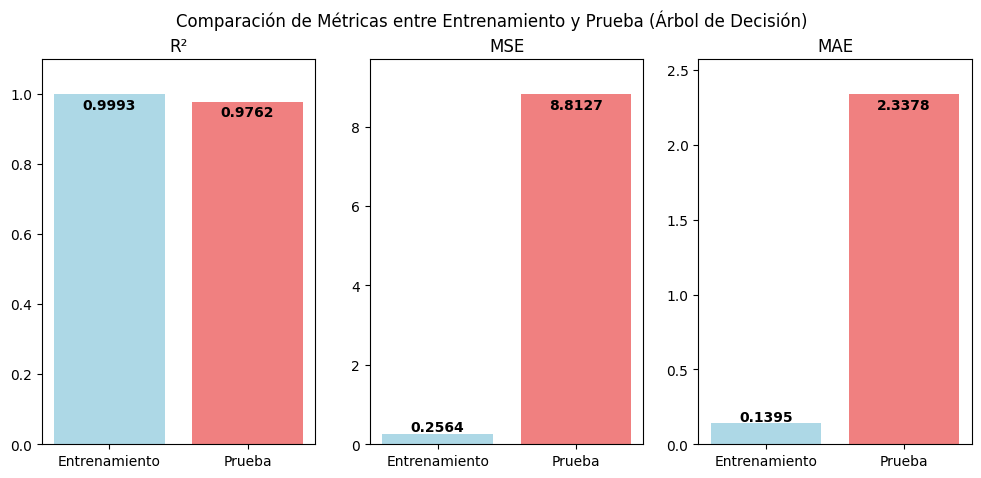

In [27]:
metric_names = ["R²", "MSE", "MAE"]
train_metrics = [r2_train_tree, mse_train_tree, mae_train_tree]
test_metrics = [r2_test_tree, mse_test_tree, mae_test_tree]

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, metric in enumerate(metric_names):
    bars = ax[i].bar(["Entrenamiento", "Prueba"], [train_metrics[i], test_metrics[i]], color=['lightblue', 'lightcoral'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, max(train_metrics[i], test_metrics[i]) * 1.1)

    for bar, value in zip(bars, [train_metrics[i], test_metrics[i]]):
        ax[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - (bar.get_height() * 0.05),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            color="black",
            fontweight="bold"
        )

plt.suptitle("Comparación de Métricas entre Entrenamiento y Prueba (Árbol de Decisión)")
plt.show()

**Análisis**

El análisis de las métricas muestra que el modelo de árbol de decisión tiene un rendimiento excelente en el conjunto de entrenamiento, con un R² cercano a 1 y errores bajos (MSE y MAE). Sin embargo, en el conjunto de prueba, el R² disminuye y los errores aumentan significativamente, por lo tanto el modelo está sobreajustado: ajusta demasiado bien a los datos de entrenamiento, pero pierde precisión en datos no vistos. Para mejorar la generalización, sería conveniente limitar la profundidad del árbol o explorar métodos de ensemble como Random Forest o Gradient Boosting, que suelen manejar mejor el sobreajuste.

## **Tunning del modelo - Regresión con árbol de decisión**

### **Busqueda de hiperparametros con Grid search CV**

In [28]:
#Definimos el espacio de búsqueda de hiperparámetros
param_grid = {'max_depth': [3, 5, 10, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}

#Configuramos la búsqueda de hiperparámetros en el árbol de decisión
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor R² obtenido:", grid_search.best_score_)

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mejor R² obtenido: 0.9830783642033294


In [29]:
#Creamos el modelo con los mejores hiperparámetros
optimized_tree_model = DecisionTreeRegressor(max_depth=10,min_samples_leaf=4,min_samples_split=10,random_state=42)
optimized_tree_model.fit(X_train, y_train)

#Realizamos predicciones en el conjunto de entrenamiento y prueba
y_train_pred_optimized = optimized_tree_model.predict(X_train)
y_test_pred_optimized = optimized_tree_model.predict(X_test)

#Calculamos métricas para el conjunto de entrenamiento
r2_train_optimized = r2_score(y_train, y_train_pred_optimized)
mse_train_optimized = mean_squared_error(y_train, y_train_pred_optimized)
mae_train_optimized = mean_absolute_error(y_train, y_train_pred_optimized)

#Calculamos métricas para el conjunto de prueba
r2_test_optimized = r2_score(y_test, y_test_pred_optimized)
mse_test_optimized = mean_squared_error(y_test, y_test_pred_optimized)
mae_test_optimized = mean_absolute_error(y_test, y_test_pred_optimized)

optimized_results = [["Entrenamiento", r2_train_optimized, mse_train_optimized, mae_train_optimized],["Prueba", r2_test_optimized, mse_test_optimized, mae_test_optimized]]
print(tabulate(optimized_results, headers=["Conjunto", "R²", "MSE", "MAE"], tablefmt="fancy_grid", floatfmt="g"))

╒═══════════════╤══════════╤════════╤═════════╕
│ Conjunto      │       R² │    MSE │     MAE │
╞═══════════════╪══════════╪════════╪═════════╡
│ Entrenamiento │ 0.990645 │ 3.4491 │ 1.46518 │
├───────────────┼──────────┼────────┼─────────┤
│ Prueba        │ 0.984277 │ 5.8267 │ 1.90349 │
╘═══════════════╧══════════╧════════╧═════════╛


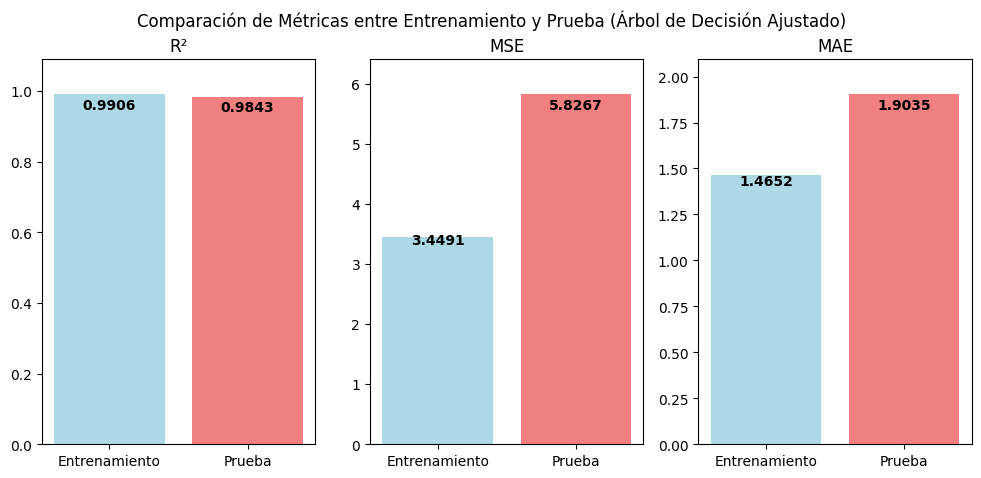

In [30]:
metric_names = ["R²", "MSE", "MAE"]
train_metrics_optimized = [r2_train_optimized, mse_train_optimized, mae_train_optimized]
test_metrics_optimized = [r2_test_optimized, mse_test_optimized, mae_test_optimized]
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

for i, metric in enumerate(metric_names):
    bars = ax[i].bar(["Entrenamiento", "Prueba"], [train_metrics_optimized[i], test_metrics_optimized[i]], color=['lightblue', 'lightcoral'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, max(train_metrics_optimized[i], test_metrics_optimized[i]) * 1.1)

    for bar, value in zip(bars, [train_metrics_optimized[i], test_metrics_optimized[i]]):
        ax[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - (bar.get_height() * 0.05),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            color="black",
            fontweight="bold"
        )

plt.suptitle("Comparación de Métricas entre Entrenamiento y Prueba (Árbol de Decisión Ajustado)")
plt.show()

**Análisis**

El árbol de decisión ajustado tiene un buen equilibrio entre el conjunto de entrenamiento y el de prueba. El R² es alto en ambos conjuntos (0.9906 en entrenamiento y 0.9843 en prueba), indicando un buen ajuste y generalización. Los errores MSE y MAE también son razonablemente cercanos entre ambos conjuntos, lo que quiere decir que el modelo no está sobreajustado y tiene una buena capacidad de predicción en datos no vistos. Este modelo ajustado ofrece un balance adecuado entre precisión y generalización.

## **Comparación de los modelos- Regresión con árbol de decisión**

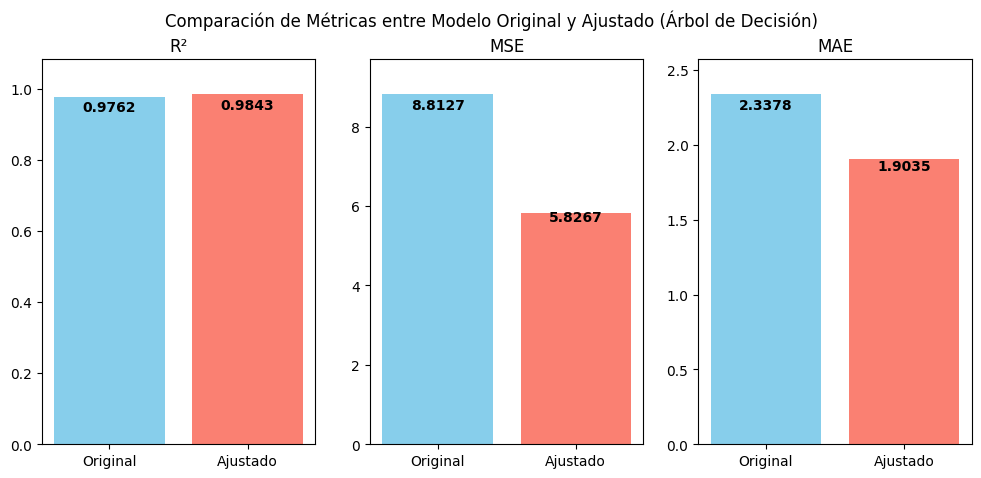

In [31]:
metric_names = ["R²", "MSE", "MAE"]
original_metrics = [r2_test_tree, mse_test_tree, mae_test_tree]
optimized_metrics = [r2_test_optimized, mse_test_optimized, mae_test_optimized]

fig, ax = plt.subplots(1, 3, figsize=(12, 5))
for i, metric in enumerate(metric_names):
    bars = ax[i].bar(["Original", "Ajustado"], [original_metrics[i], optimized_metrics[i]], color=['skyblue', 'salmon'])
    ax[i].set_title(metric)
    ax[i].set_ylim(0, max(original_metrics[i], optimized_metrics[i]) * 1.1)

    for bar, value in zip(bars, [original_metrics[i], optimized_metrics[i]]):
        ax[i].text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() - (bar.get_height() * 0.05),
            f"{value:.4f}",
            ha="center",
            va="bottom",
            color="black",
            fontweight="bold"
        )

plt.suptitle("Comparación de Métricas entre Modelo Original y Ajustado (Árbol de Decisión)")
plt.show()

**Análisis**

El modelo ajustado muestra un rendimiento superior en todas las métricas evaluadas, lo que indica que los hiperparámetros optimizados han mejorado tanto la precisión como la generalización del modelo. Esta mejora es evidente en la reducción de los errores (MSE y MAE) y el incremento en R², haciendo del modelo ajustado una opción más confiable para predicciones.